# Lecture 14: Introduction to Time Series Analysis

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture14.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.


# Modeling Toolkit For Time Series Analysis

<a id='toc'></a>

## This notebook includes:

[Fourier Analysis](#fourier)

[Discrete Fourier Transform](#dft) 

[An example: estimating period for variable stars](#periods)

[Digital Filtering](#filtering) 

[Bonus topic: Analysis of Stochastic Processes](#stochastic)

## Introduction
In this lecture, we are going to learn a few fundamental concepts and tools for analyzing time series data. From an astronomical perspective, this field has predominantly focused on unevenly sampled data, low signal-to-noise data, and heteroscedastic errors. The most common applications range from the detection of variability and periodicity to the treatment of nonperiodic
variability and searches for localized events.  

Despite being set in the context of time series, many tools and results are readily applicable in other domains, which we will see later in this notebook. We will extend this toolkit by introducing tools for analysis
in the frequency domain, such as digital filtering.  

The main data sets used in this chapter include light curves obtained by the [LINEAR survey](https://arxiv.org/abs/1505.02082) (Lincoln Near-Earth Asteroid Research).

## Main concepts for time series analysis
The time series discussed here will be limited to two-dimensional scalar data sets: pairs of random variables, ($t_1$, $y_1$),...,($t_N$; $y_N$), with no assumptions about the sampling of the time coordinate t. In many ways, analysis methods discussed here are closely related to the parameter estimation and model selection problems discussed in the context of regression. However, unlike regression problems where different y measurements are typically treated as independent random
variables, **for time-series models the value of $y_{i+1}$ directly depends on the preceding value $y_i$**.  
  
The main tasks of time series analysis are:  
1. To characterize the presumed temporal correlation between different values of y, including its significance.  
2. To forecast (predict) future values of y.

### Import Functions and Packages

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

from scipy.signal import fftconvolve

from scipy import fftpack
from matplotlib import mlab

from astroML.datasets import fetch_LIGO_large

from scipy.fftpack import fft
from scipy.stats import norm

from astroML.fourier import PSD_continuous

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(usetex=True)

## 1. Fourier analysis <a id='fourier'></a>
[Go to top](#toc)

Fourier analysis plays a major role in the analysis of time series data. In Fourier analysis, general
functions are represented or approximated by integrals or sums of simpler trigonometric functions.   

For periodic functions, such as periodic light curves
in astronomy, it is often true that a relatively small number of terms (less than 10) suffices to reach
an approximation precision level similar to the measurement precision.

## Some useful concepts
The **Fourier transform** of function h(t) is defined as

$$H(f)=\int_{-\infty}^{\infty} h(t) exp(-i2\pi ft)dt$$

with **inverse transformation**

$$h(t)=\int_{-\infty}^{\infty} H(t) exp(-i2\pi ft)df$$

where t is time and f is frequency (for time in seconds, the unit for frequency is hertz, or Hz; the
units for H(f) are the product of the units for h(t) and inverse hertz.  
For a real function h(t), H(f) is in general a complex function.  
In the special case when h(t) is an even function such that h(-t) = h(t), H(f) is real and even as well. For example, the
Fourier transform of a pdf of a zero-mean Gaussian $N(0, \sigma)$ in the time domain is a Gaussian
$H(f) = exp(-2\pi^2 \sigma^2 f^2)$ in the frequency domain.  
When the time axis of an arbitrary function
h(t) is shifted by $\Delta t$, then the Fourier transform of $h(t + \Delta t)$ is

$$\int_{-\infty}^{\infty}h(t+\Delta t)exp(-i2\pi ft)dt = H(f)exp(i2\pi f\Delta t)$$

Therefore, the **Fourier transform of a Gaussian $N(\mu, \sigma)$** is

$$H_{Gauss}(f)=exp(-2\pi^2\sigma^2f^2)[cos(2\pi f\mu)+isin(2\pi f \mu)]$$

This is known as **"white noise"** since there is no frequency
dependence (also known as "thermal noise" or Johnson's noise).  
An important quantity in time series analysis is the one-sided **power spectral density (PSD)** function
(or power spectrum) defined for $0 \leq f < \infty$ as

$$PSD(f) \equiv |H(f)|^2+|H(-f)|^2$$

The PSD gives the amount of power contained in the frequency interval between f and f + df.  
The total power is the same whether computed in the frequency or the time domain:

$$P_{tot} \equiv \int_0^{\infty}PSD(f)df=\int_{-\infty}^{\infty}|h(t)|^2dt$$

This result is known as **Parseval's theorem**.

### 1.1 Fourier Reconstruction of RR-Lyrae Templates
Below is an example of a truncated Fourier representation of an RR Lyrae light curve. As we can see, the more terms that are included in the sum, the better is the resulting approximation.

#### Import a RR Lyrae template
From astroML.datasets, we take the RR Lyrae (variable star) light curve as an example. RR Lyrae has a periodical pulsation.

In [3]:
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#### Show Fourier reconstruction results
The thick dashed line shows the true curve; the gray lines show the approximation based on 1, 3, and 8 Fourier modes (sinusoids).

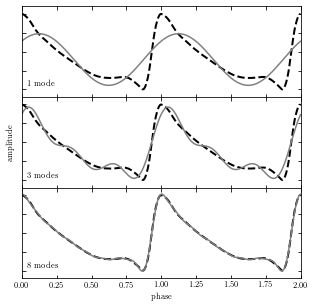

In [4]:
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

### 1.2 Convolution Theorem
A convolution of two functions $a(t)$ and $b(t)$ is given by

$$(a*b)(t) \equiv \int_{-\infty}^{\infty} a(t')b(t-t')dt'$$

In the above equation, the function a can
be thought of as the "convolving pattern" of the measuring apparatus, and the function $b$ is the
signal. In practice, we measure the convolved (or smoothed) version of our signal, $[a * b](t)$, and
seek to uncover the original signal $b$ using the presumably known $a$.  
The convolution theorem states that if $h = a * b$, then the Fourier transforms of $h$, $a$, and $b$ are
related by their pointwise products:

$$H(f)=A(f)B(f)$$

Thus a convolution of two functions is transformed into a simple multiplication of the associated
Fourier representations. Therefore, to obtain $b$, we can simply take the inverse Fourier transform
of the ratio $H(f)=A(f)$. In the absence of noise, this operation is exact.  
  
For further explanation, we will see a schematic representation of the convolution theorem below.

## 2. Discrete Fourier Transform<a id='dft'></a>
[Go to top](#toc)

In practice, data are always discretely sampled. When the spacing of the time interval is constant,
the discrete Fourier transform is a powerful tool.
Although in astronomy, temporal data are rarely sampled with uniform spacing (LIGO data, however, as a counterexample, will be discussed in the later notebook), uniformly sampled data is a good place to start because we have fast algorithm for this situation.  
When computing the Fourier transform for discretely and uniformly sampled data, the Fourier
integrals from 

$$H(f)=\int_{-\infty}^{\infty} h(t) exp(-i2\pi ft)dt$$
$$h(t)=\int_{-\infty}^{\infty} H(t) exp(-i2\pi ft)df$$

are translated to sums. Here we have t for time and f for frequency.
  
The discrete Fourier transform of the vector of values hj is a complex vector of length N defined
by

$$H_k=\sum_{j=0}^{N-1}h_j exp[-i2\pi jk/N]$$

where k=0,...,(N-1).  
The corresponding inverse discrete Fourier transform is defined by

$$h_j=\sum_{j=0}^{N-1}H_k exp[-i2\pi jk/N]$$

where j=0,...,(N-1). Unlike the continuous transforms, here the units for $H_k$ are the same as
the units for $h_j$ . Given $H_k$, we can represent the function described by $h_j$ as a sum of sinusoids,
as was done in the first figure.

### 2.1 The Nyquist sampling theorem
Let us define $h(t)$ to be band limited if $H(f) = 0$ for $|f| > f_c$, where $f_c$ is the band limit, or the
Nyquist critical frequency. If $h(t)$ is band limited, then there is some "resolution" limit in $t$ space,
$t_c = 1/(2f_c)$ below which h(t) appears "smooth." When $h(t)$ is band limited, then according to the Nyquist sampling theorem we can exactly reconstruct h(t) from evenly sampled data when $\Delta t < t_c$,
as

$$h(t)=\frac{\Delta t}{t_c} \sum_{k=-\infty}^{k=\infty} h_k \frac{sin[2\pi f_c (t-k\Delta t)]}{2\pi f_c (t-k\Delta t)}$$

This result is known as the Whittaker-Shannon, or often just Shannon, interpolation formula
(or "sinc-shifting" formula).  
Note that the summation goes to infinity, but also that the term
multiplying $h_k$ vanishes for large values of $|t - k\Delta t|$.  
For example $h(t) = sin(2 \pi t/P )$ has a period
P and is band limited with $f_c = 1/P$. If it is sampled with $\Delta t$ not larger than $P/2$, it can be fully
reconstructed at any $t$ (it is important to note that this entire discussion assumes that there is no
noise associated with sampled values $h_j$ ). On the other hand, when the sampled function h(t) is not
band limited, or when the sampling rate is not sufficient (i.e., $\Delta t > t_c$), an effect called **"aliasing"**
prevents us from exactly reconstructing h(t). In such a case, all of the power
spectral density from frequencies $|f| > f_c$ is aliased (falsely transferred) into the $-f_c < f < f_c$
range. The aliasing can be thought of as inability to resolve details in a time series at a finer detail
than that set by $f_c$. The figure below will show us the effect of aliasing.

### 2.2 The Fast Fourier Transform (FFT)
The **Fast Fourier transform (FFT)** is an algorithm for computing discrete Fourier transforms in
O(N logN) time, rather than O(N2) using a naive implementation. The algorithmic details for
the FFT can be found in NumRec. The speed of FFT makes it a widespread tool in the analysis
of evenly sampled, high signal-to-noise ratio, time series data.  
An example below shows such analysis for a function with a single dominant frequency: a sine wave whose amplitude is modulated by a Gaussian.

#### Generate the data

In [5]:
np.random.seed(1)

tj = np.linspace(-25, 25, 512)
hj = np.sin(tj)
hj *= norm(0, 10).pdf(tj)

#### Show result with data and calculated PSD
The discrete Fourier transform (bottom panel) for two noisy data sets shown in the top panel. For 512 evenly sampled times t (dt = 0.977), points are drawn from h(t) = a + sin(t)G(t), where G(t) is a Gaussian N(mu = 0,sigma = 10). Gaussian noise with sigma = 0.05 (top data set) and 0.005 (bottom data set) is added to signal h(t). The value of the offset a is 0.15 and 0, respectively. The discrete Fourier transform is computed as described in this section. For both noise realizations, the correct frequency f = (2pi)-1 ~ 0.159 is easily discernible in the bottom panel. Note that the height of peaks is the same for both noise realizations. The large value of abs(H(f = 0)) for data with larger noise is due to the vertical offset.

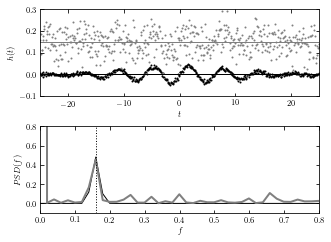

In [6]:
# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.35)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

offsets = (0, 0.15)
colors = ('black', 'gray')
linewidths = (1, 2)
errors = (0.005, 0.05)

for (offset, color, error, linewidth) in zip(offsets, colors,
                                             errors, linewidths):
    # compute the PSD
    err = np.random.normal(0, error, size=hj.shape)
    hj_N = hj + err + offset
    fk, PSD = PSD_continuous(tj, hj_N)

    # plot the data and PSD
    ax1.scatter(tj, hj_N, s=4, c=color, lw=0)
    ax1.plot(tj, 0 * tj + offset, '-', c=color, lw=1)
    ax2.plot(fk, PSD, '-', c=color, lw=linewidth)

# vertical line marking the expected peak location
ax2.plot([0.5 / np.pi, 0.5 / np.pi], [-0.1, 1], ':k', lw=1)

ax1.set_xlim(-25, 25)
ax1.set_ylim(-0.1, 0.3001)

ax1.set_xlabel('$t$')
ax1.set_ylabel('$h(t)$')

ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax2.set_xlim(0, 0.8)
ax2.set_ylim(-0.101, 0.801)

ax2.set_xlabel('$f$')
ax2.set_ylabel('$PSD(f)$')

plt.show()

## 3. An example: estimating period for variable stars<a id='periods'></a>
[Go to top](#toc)

The code below is essentially the code that generates Figure 10.17 in the textbook, see
https://www.astroml.org/book_figures/chapter10/fig_LINEAR_LS.html

That code:
* downloads a dataset of variable stars collected with the [LINEAR](https://en.wikipedia.org/wiki/Lincoln_Near-Earth_Asteroid_Research) telescope,
* selects six of them (as given by the `ids` variable),
* computes the Lomb-Scargle periodogram in the `compute_best_frequencies` function,
* finds the best frequency by looking for the highest peak in the periodiogram, and
* folds the light curves and plots the results.

We will below modify that code to do the following:

1. Find the frequencies for the first 100 stars in the LINEAR datasets (i.e., those with IDs in `data.ids[:100]`, where `data` is the variable containing the LINEAR dataset as defined below).

2. Compute the periods corresponing to the frequencies above, and plot the histogram of periods using 50 bins in range $0 < T < 25$ hours.  

3. Generate two 6-panel figures analogous to Figure 10.17, for 6 stars (arbitrarily chosen) from the highest and second highest peak, respectivelly.  

In [7]:
# Figure 10.17 code

# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print(" - computing power for %i (%i points)" % (i, len(t)))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

# plot phased light curves 
def plot_lightcurves(results, ids):
    #------------------------------------------------------------
    # Plot the phased light-curves
    fig = plt.figure(figsize=(5, 6.5))
    fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

    for i in range(len(ids)):
        # get the data and best-fit angular frequency
        t, y, dy = data[ids[i]].T
        omega, power = results[ids[i]]
        omega_best = omega[np.argmax(power)]
        print(" - omega_0 = %.10g" % omega_best)

        # do a fit to the first 4 Fourier components
        mtf = MultiTermFit(omega_best, 4)
        mtf.fit(t, y, dy)
        phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

        # plot the phased data and best-fit curves
        ax = fig.add_subplot(321 + i)
        ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                    lw=1, ms=4, capsize=1.5)
        ax.plot(phase_fit, y_fit, '-b', lw=2)

        ax.set_xlim(0, 1)
        ax.set_ylim(plt.ylim()[::-1])
        ax.yaxis.set_major_locator(plt.MaxNLocator(4))

        ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
                transform=ax.transAxes)
        ax.text(0.03, 0.96, "P = %.2f hr" % (2 * np.pi / omega_best * 24.),
                ha='left', va='top',
                transform=ax.transAxes)

        ylim = ax.get_ylim()
        ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

        if i < 4:
            ax.xaxis.set_major_formatter(plt.NullFormatter())
        if i % 2 == 0:
            ax.set_ylabel('mag')

        if i in (4, 5):
            ax.set_xlabel('phase')

    return fig 

In [8]:
# Load the dataset
data = fetch_LINEAR_sample()

@pickle_results: computing results and saving to 'LINEAR_LS.pkl'
    - args match:   False
    - kwargs match: True
 - computing power for 14752041 (253 points)
 - computing power for 1009459 (593 points)
 - computing power for 10022663 (246 points)
 - computing power for 10025796 (233 points)
 - computing power for 11375941 (280 points)
 - computing power for 18525697 (211 points)
 - omega_0 = 17.21695506
 - omega_0 = 51.10600808
 - omega_0 = 10.20062676
 - omega_0 = 45.55493503
 - omega_0 = 58.44512277
 - omega_0 = 10.82722772


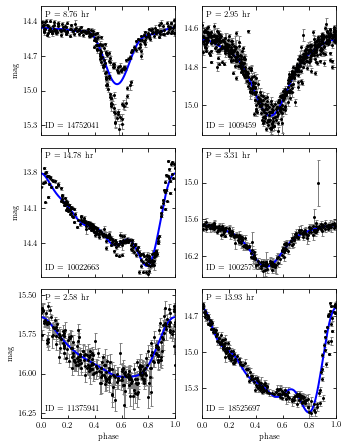

In [9]:
# select a subset of the full dataset
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]

# Compute the best frequencies
results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

# Plot the phased light-curves
myprettyplot = plot_lightcurves(results, ids)

In [10]:
# read data and process the first 100 stars
data = fetch_LINEAR_sample()
Nlightcurve = 100

# if you are brave you can do all 7009! 
#  it took about 5 hours on my laptop
# if you want to do that, uncomment this line: 
# Nlightcurve = data.ids[:-1].size

ids = data.ids[:Nlightcurve]
results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

omegas = np.zeros(len(ids))
for i in range(len(ids)):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T
    omega, power = results[ids[i]]
    omega_best = omega[np.argmax(power)]
    omegas[i] = omega_best
    print(" - Star #%4d: omega_0, T_0 = %.10g, %.10g" % (i, omega_best, (2 * np.pi / omega_best * 24.)))


@pickle_results: computing results and saving to 'LINEAR_LS.pkl'
    - args match:   False
    - kwargs match: True
 - computing power for 10003298 (196 points)
 - computing power for 10004892 (269 points)
 - computing power for 10013411 (170 points)
 - computing power for 10021274 (214 points)
 - computing power for 10022663 (246 points)
 - computing power for 10025796 (233 points)
 - computing power for 10028253 (38 points)
 - computing power for 10030349 (255 points)
 - computing power for 10032668 (193 points)
 - computing power for 10038903 (227 points)
 - computing power for 10040133 (257 points)
 - computing power for 10040491 (228 points)
 - computing power for 10045187 (229 points)
 - computing power for 10045615 (101 points)
 - computing power for 10046720 (136 points)
 - computing power for 10047498 (221 points)
 - computing power for 1004849 (607 points)
 - computing power for 1005497 (607 points)
 - computing power for 10064356 (291 points)
 - computing power for 10066464 

 - Star #  95: omega_0, T_0 = 56.54226528, 2.666968623
 - Star #  96: omega_0, T_0 = 50.59428576, 2.980503531
 - Star #  97: omega_0, T_0 = 12.04101654, 12.52356451
 - Star #  98: omega_0, T_0 = 45.47848749, 3.315775341
 - Star #  99: omega_0, T_0 = 40.86776995, 3.689862392


In [11]:
# Convert frequencies to periods (in hours):
TT = (2 * np.pi / omegas * 24.)

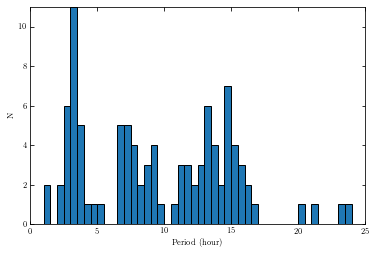

In [12]:
# Construct and plot the histogram of periods:
n, bins, patches = plt.hist(TT, 50, range=(0,25))
plt.xlabel('Period (hour)')
plt.ylabel('N')
plt.show()

In [13]:
# Now pick 6 ids close to the first and second peaks (determined by eyeballing of the above diagram):
ids_peak1 = ids[(TT >= 3) & (TT < 3.5)][:6]
ids_peak1

array([10025796, 10101561, 10127760, 10178648, 10195209, 10304077])

In [14]:
ids_peak2 = ids[(TT >= 14) & (TT < 16)][:6]
ids_peak2

array([10022663, 10040133, 10046720,  1005497, 10064356, 10066464])

 - omega_0 = 45.55493503
 - omega_0 = 44.9335195
 - omega_0 = 45.77922442
 - omega_0 = 47.68349511
 - omega_0 = 44.99004599
 - omega_0 = 49.51997338


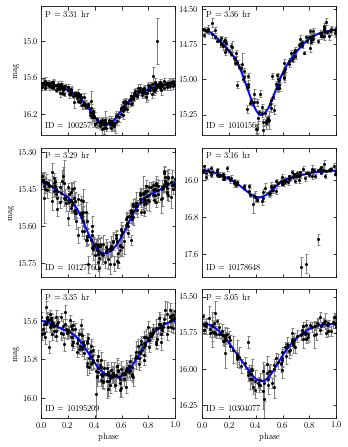

In [15]:
# And plot the two diagrams:
p1 = plot_lightcurves(results, ids_peak1)

 - omega_0 = 10.20062676
 - omega_0 = 10.29120901
 - omega_0 = 10.0363784
 - omega_0 = 9.613121674
 - omega_0 = 10.00077894
 - omega_0 = 9.448396134


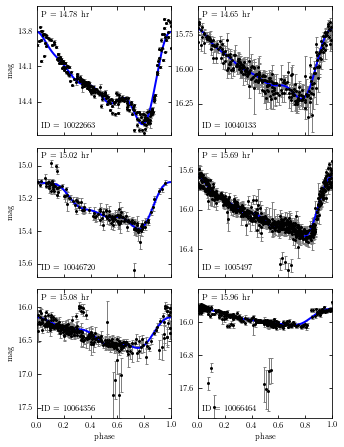

In [16]:
p2 = plot_lightcurves(results, ids_peak2)


## 4. Digital Filtering <a id='filtering'></a>
[Go to top](#toc)

## Introduction
**Digital filtering** aims to reduce noise in time series data, or to compress data. Common examples
include low-pass filtering, where high frequencies are suppressed, high-pass filtering, where low
frequencies are suppressed, passband filtering, where only a finite range of frequencies is admitted,
and a notch filter, where a finite range of frequencies is blocked. We will use a few examples to illustrate the most common
applications of filtering.  
Fourier analysis is one of the most useful tools for performing filtering. Numerous other techniques can be found in signal processing literature, including approaches based on the wavelets discussed in the modeling toolkit notebook.   
  
We emphasize that filtering always decreases the information content of data (despite making
it appear less noisy). As we have already learned throughout previous chapters, when model
parameters are estimated from data, raw (unfiltered) data should be used. In some sense, this is
an analogous situation to binning data to produce a histogram-while very useful for visualization, estimates of model parameters can become biased if one is not careful.

### Import packages and data
In this notebook, we are going to explore the astroML.filters. We mainly use the Savitzky-Golay and the Wiener filters. The spectrum of a white dwarf data imported for this notebook is from Sloan Digital Sky
Survey (SDSS).

In [17]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.fourier import PSD_continuous
from astroML.datasets import fetch_sdss_spectrum

from scipy import optimize, fftpack, interpolate
from scipy.signal import savgol_filter
from astroML.fourier import IFT_continuous
from astroML.filters import wiener_filter
from astroML.filters import min_component_filter

### 4.1 Low-pass filters
The power spectrum for common Gaussian noise is 
at and will extend to frequencies as high as
the Nyquist limit, $f_N = 1=(2\Delta t)$. If the data are band limited to a lower frequency, $f_c < f_N$, then
they can be smoothed without much impact by suppressing frequencies $|f| > f_c$. Given a filter
in frequency space, $\Phi (f)$, we can obtain a smoothed version of data by taking the inverse Fourier
transform of

$$\hat{Y}(f)=Y(f) \Phi(f)$$

where $Y(f)$ is the discrete Fourier transform of data. At least in principle, we could simply set
$\Phi(f)$ to zero for $|f| > f_c$, but this approach would result in ringing (i.e., unwanted oscillations)
in the signal. Instead, the optimal filter for this purpose is constructed by minimizing the MISE
between $\hat{Y}(f)$ and $Y(f)$ (for detailed derivation see NumRec) and is called the **Wiener filter**:

$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$

Here $P_S(f)$ and $P_N(f)$ represent components of a two-component (signal and noise) fit to the
PSD of input data, $PSD_Y (f) = P_S(f) + P_N(f)$, which holds as long as the signal and noise are
uncorrelated. We will see how the filtering works in the example below.

### Create the noisy data
We are going to generate a set of noisy data as the input signal, on which we apply filters. The figure below shows the input data (200 evenly spaced points) with a narrow Gaussian peak centered at x = 20.

Text(0, 0.5, 'flux')

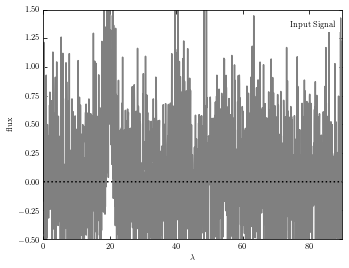

In [18]:
# Create the noisy data
np.random.seed(5)
N = 2000
dt = 0.05

t = dt * np.arange(N)
h = np.exp(-0.5 * ((t - 20.) / 1.0) ** 2)
hN = h + np.random.normal(0, 0.5, size=h.shape)

# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05, hspace=0.35,
                    bottom=0.1, top=0.95,
                    left=0.12, right=0.95)

# First plot: noisy signal
ax = fig.add_subplot(111)
ax.plot(t, hN, '-', c='gray')
ax.plot(t, np.zeros_like(t), ':k')
ax.text(0.98, 0.95, "Input Signal", ha='right', va='top',
        transform=ax.transAxes, bbox=dict(fc='w', ec='none'))

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

### Set up the Wiener filter
We fit a model to the PSD consisting of the sum of a gaussian and white noise using **Wiener filter**. We will see this method in the later sections in this notebook.  

In [19]:
N = 2000

Df = 1. / N / dt
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

# apply the Wiener filter
h_smooth, PSD, P_S, P_N, Phi = wiener_filter(t, hN, return_PSDs=True)

### Set up the Savitzky-Golay filter
We use a fourth-order **Savitzky-Golay** filter with a window size of $\Delta \lambda = 10$ to filter the vales. 
The Savitzky-Golay filter is a very simple but powerful method as a low-pass filter. It fits low-order polynomials
to data (in the time domain) using sliding windows (it is also known as the least-squares filter).
For a detailed discussion, see NumRec.

In [20]:
# apply the Savitzky-Golay filter
h_sg = savgol_filter(hN, window_length=201, polyorder=4, mode='mirror')

### Show filtered signal
Plot below shows noisy signal after filtering. 
* Result from Wiener filter is shown in black.
* Result from Savitzky-Golay filter is shown in gray.  

The Gaussian peak at x=20 is clearly seen in both curves.

Text(0, 0.5, 'flux')

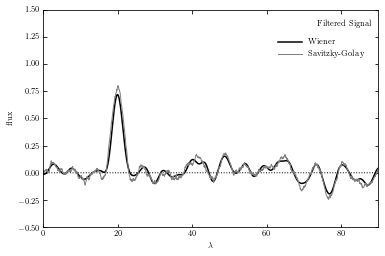

In [21]:
# Second plot: filtered signal
ax = plt.subplot(111)
ax.plot(t, np.zeros_like(t), ':k', lw=1)
ax.plot(t, h_smooth, '-k', lw=1.5, label='Wiener')
ax.plot(t, h_sg, '-', c='gray', lw=1, label='Savitzky-Golay')

ax.text(0.98, 0.95, "Filtered Signal", ha='right', va='top',
        transform=ax.transAxes)
ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.9), frameon=False)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('flux')

### Show filtered PSD
* The upper panel shows the input power spectral density (PSD) distribution.  
* The lower panel shows the Wiener-filtered power spectral density (PSD) distributions.  

The two curves in the upper panel represent two-component fit to PSD given by equation

$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$

Text(0, 0.5, '$PSD(f)$')

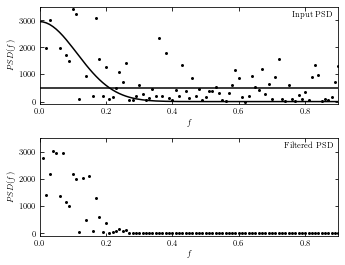

In [22]:
# Plot the results
N = len(t)
Df = 1. / N / (t[1] - t[0])
f = fftpack.ifftshift(Df * (np.arange(N) - N / 2))
HN = fftpack.fft(hN)

fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(wspace=0.05, hspace=0.35,
                    bottom=0.1, top=0.95,
                    left=0.12, right=0.95)

# Third plot: Input PSD
ax = fig.add_subplot(211)
ax.scatter(f[:N // 2], PSD[:N // 2], s=9, c='k', lw=0)
ax.plot(f[:N // 2], P_S[:N // 2], '-k')
ax.plot(f[:N // 2], P_N[:N // 2], '-k')

ax.text(0.98, 0.95, "Input PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

# Fourth plot: Filtered PSD
ax = fig.add_subplot(212)
filtered_PSD = (Phi * abs(HN)) ** 2
ax.scatter(f[:N // 2], filtered_PSD[:N // 2], s=9, c='k', lw=0)

ax.text(0.98, 0.95, "Filtered PSD", ha='right', va='top',
        transform=ax.transAxes)

ax.set_ylim(-100, 3500)
ax.set_xlim(0, 0.9)

ax.yaxis.set_major_locator(plt.MultipleLocator(1000))
ax.xaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.set_xlabel('$f$')
ax.set_ylabel('$PSD(f)$')

### Wiener Filter and kernel smoothing Connection
There is an interesting connection between the kernel density estimation method discussed in the KDE notebook
and Wiener filtering. By the convolution theorem, the Wiener-filtered result is equivalent to the
convolution of the unfiltered signal with the inverse Fourier transform of $\Phi(f)$.  

This convolution is equivalent to kernel density estimation. When Wiener filtering is viewed in this way, it effectively says that we believe the signal is as wide as the central
peak, and the statistics of the noise are such that the minor peaks in the
wings work to cancel out noise in the major peak.  

Hence, the modeling of the PSD in the frequency
domain via 

$$\Phi(f) = \frac{P_S(f)}{P_S(f)+P_N(f)}$$ 

corresponds to choosing the optimal kernel width. Just as detailed modeling
of the Wiener filter is not of paramount importance, the choice of kernel is not either.

We will use the same data as the previous Wiener filter figure as an example to explore this connection.

### Find effective kernel

In [23]:
# inverse fourier transform Phi to find the effective kernel
t_plot, kernel = IFT_continuous(f, Phi)

### perform kernel smoothing
This is faster in frequency
space (i.e. using the standard Wiener filter above) but we will do it in the slow & simple way here to demonstrate the equivalence explicitly.

In [24]:
kernel_func = interpolate.interp1d(t_plot, kernel.real)

t_eval = np.linspace(0, 90, 1000)
t_KDE = t_eval[:, np.newaxis] - t
t_KDE[t_KDE < t_plot[0]] = t_plot[0]
t_KDE[t_KDE > t_plot[-1]] = t_plot[-1]
F = kernel_func(t_KDE)

h_smooth = np.dot(F, hN) / np.sum(F, 1)

### Show kernel and smoothing results
* The left panel shows the inverse Fourier transform of the Wiener filter $\Phi(f)$ applied in the sample data we used previously.  
* The right panel shows the data smoothed by this kernel, which is equivalent to the Wiener filter smoothing in the previous figure.  

By the convolution theorem, the Wiener-filtered result is equivalent to the convolution of the unfiltered signal with
the kernel shown above, and thus Wiener filtering and kernel density estimation (KDE) are directly related. 

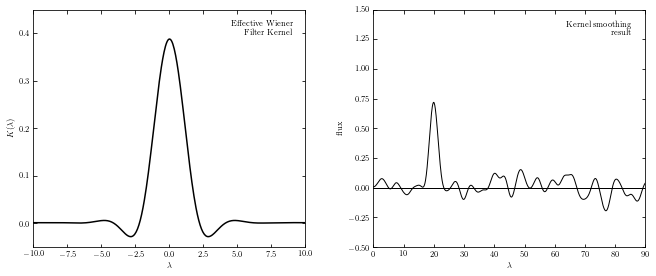

In [25]:
# Plot the results
fig = plt.figure(figsize=(10, 4.4))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.9)

# First plot: the equivalent Kernel to the WF
ax = fig.add_subplot(121)
ax.plot(t_plot, kernel.real, '-k')
ax.text(0.95, 0.95, "Effective Wiener\nFilter Kernel",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.05, 0.45)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$K(\lambda)$')

# Second axes: Kernel smoothed results
ax = fig.add_subplot(122)
ax.plot(t_eval, h_smooth, '-k', lw=1)
ax.plot(t_eval, 0 * t_eval, '-k', lw=1)
ax.text(0.95, 0.95, "Kernel smoothing\nresult",
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(0, 90)
ax.set_ylim(-0.5, 1.5)

ax.set_xlabel('$\lambda$')
ax.set_ylabel('flux')

plt.show()

## 4.2 High-pass filters
The most common example of high-pass filtering in astronomy is baseline estimation in spectral
data. Unlike the case of low-pass filtering, here there is no universal filter recipe. Baseline estimation
is usually the first step toward the estimation of model parameters (e.g. location, width, and strength of spectral lines). In such cases, the best approach might be full modeling and
marginalization of baseline parameters as nuisance parameters at the end of analysis.  
  
A simple iterative technique for high-pass filtering, called **minimum component filtering**, is discussed
in detail in WJ03. These are the **main steps**:
1. Determine baseline: exclude or mask regions where signal is clearly evident and fit a baseline
model (e.g., a low-order polynomial) to the unmasked regions.
2. Get FT for the signal: after subtracting the baseline fit in the unmasked regions (i.e., a linear
regression fit), apply the discrete Fourier transform.
3. Filter the signal: remove high frequencies using a low-pass filter (e.g., Wiener filter), and
inverse Fourier transform the result.
4. Recombine the baseline and the filtered signal: add the baseline fit subtracted in step 2 to
the result from step 3. This is the minimum component filtering estimate of baseline.  
  
In the next two examples, we will see the application of a minimum component filter to the spectrum of a white dwarf.

## Example 1 
### Fetch the data
We first fetch the spectrum data from SDSS database for use. The intermediate steps of the minimum component filter procedure applied to the spectrum of a white dwarf from the SDSS data set (mjd= 52199, plate=659, fiber=381).

In [26]:
# Fetch the spectrum from SDSS database
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

### Pre-process the data
Wavelengths we get are logorithmically spaced: we will work in log(lam).

In [27]:
def preprocess(lam, spec):
    loglam = np.log10(lam)

    flag = (lam > 4000) & (lam < 5000)
    lam = lam[flag]
    loglam = loglam[flag]
    spec = spec[flag]

    lam = lam[:-1]
    loglam = loglam[:-1]
    spec = spec[:-1]
    
    return [lam, loglam, spec]

[lam, loglam, spec] = preprocess(lam, spec)

### Apply minimum component filtering steps

First step: mask-out significant features

In [28]:
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))

Second step: fit a line to the unmasked portion of the spectrum

In [29]:
XX = loglam[:, None] ** np.arange(2)
beta = np.linalg.lstsq(XX[~feature_mask], spec[~feature_mask], rcond=None)[0]

spec_fit = np.dot(XX, beta)
spec_patched = spec - spec_fit
spec_patched[feature_mask] = 0

Third step: Fourier transform the patched spectrum

In [30]:
N = len(loglam)
df = 1. / N / (loglam[1] - loglam[0])
f = fftpack.ifftshift(df * (np.arange(N) - N / 2.))
spec_patched_FT = fftpack.fft(spec_patched)

Fourth step: Low-pass filter on the transform

In [31]:
filt = np.exp(- (0.01 * (abs(f) - 100.)) ** 2)
filt[abs(f) < 100] = 1

spec_filt_FT = spec_patched_FT * filt

Fifth step: inverse Fourier transform, and add back the fit

In [32]:
spec_filt = fftpack.ifft(spec_filt_FT)
spec_filt += spec_fit

### Show filter result
* The top panel shows the input spectrum; the masked sections of the input spectrum are shown by thin lines (i.e., step 1 of the process). 
* The bottom panel shows the PSD of the masked spectrum, after the linear fit has been subtracted (gray line). 
* A simple low-pass filter (dashed line) is applied, and the resulting filtered spectrum (dark line) is used to construct the result shown in the next figure.

Text(0, 0.5, 'scaled $PSD(f)$')

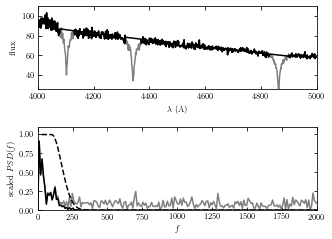

In [33]:
# plot results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.45)

ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray')
ax.plot(lam, spec_patched + spec_fit, '-k')

ax.set_ylim(25, 110)
ax.set_xlim(4000, 5000)

ax.set_xlabel(r'$\lambda\ {\rm(\AA)}$')
ax.set_ylabel('flux')

ax = fig.add_subplot(212)
factor = 15 * (loglam[1] - loglam[0])
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_patched_FT) ** 1),
        '-', c='gray', label='masked/shifted spectrum')
ax.plot(fftpack.fftshift(f),
        factor * fftpack.fftshift(abs(spec_filt_FT) ** 1),
        '-k', label='filtered spectrum')
ax.plot(fftpack.fftshift(f),
        fftpack.fftshift(filt), '--k', label='filter')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 1.1)

ax.set_xlabel('$f$')
ax.set_ylabel('scaled $PSD(f)$')

## Example 2 (use package)
### Fetch the data
We follow the same process to analyze the same white dwarf example. Here instead of explicitly applying steps, we call function *min_component_filter* to achieve the same goal.

In [34]:
plate = 659
mjd = 52199
fiber = 381

data = fetch_sdss_spectrum(plate, mjd, fiber)

lam = data.wavelength()
spec = data.spectrum

### Pre-process the data

In [35]:
[lam, loglam, spec] = preprocess(lam,spec)

### Apply minimum component filtering using function
The function used here is *min_component_filter* in *astroML.filters* package.

In [36]:
feature_mask = (((lam > 4080) & (lam < 4130)) |
                ((lam > 4315) & (lam < 4370)) |
                ((lam > 4830) & (lam < 4900)))

spec_filtered = min_component_filter(loglam, spec, feature_mask, fcut=100)

### Compute PSD of filtered and unfiltered versions

In [37]:
f, spec_filt_PSD = PSD_continuous(loglam, spec_filtered)
f, spec_PSD = PSD_continuous(loglam, spec)

### Show filter result
* The upper panel shows a portion of the input spectrum, along with the continuum computed via the minimum component filtering procedure described above (See the previous figure). 
* The lower panel shows the PSD for both the input spectrum and the filtered result.

(0.0, 2000.0)

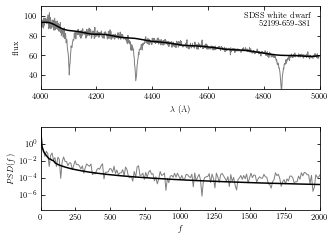

In [38]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(hspace=0.45)

# Top panel: plot noisy and smoothed spectrum
ax = fig.add_subplot(211)
ax.plot(lam, spec, '-', c='gray', lw=1)
ax.plot(lam, spec_filtered, '-k')

ax.text(0.97, 0.93, "SDSS white dwarf\n %i-%i-%i" % (mjd, plate, fiber),
        ha='right', va='top', transform=ax.transAxes)

ax.set_ylim(25, 110)
ax.set_xlim(4000, 5000)

ax.set_xlabel(r'$\lambda\ {\rm (\AA)}$')
ax.set_ylabel('flux')

# Bottom panel: plot noisy and smoothed PSD
ax = fig.add_subplot(212, yscale='log')
ax.plot(f, spec_PSD, '-', c='gray', lw=1)
ax.plot(f, spec_filt_PSD, '-k')

ax.set_xlabel(r'$f$')
ax.set_ylabel('$PSD(f)$')
ax.set_xlim(0, 2000)

## Bonus topic: Analysis of Stochastic Processes<a id='stochastic'></a>
[Go to top](#toc)

### Introduction
Stochastic variability includes behavior that is not predictable forever as in the periodic case, but
unlike temporally localized events, variability is always there. Typically, the underlying physics is
so complex that we cannot deterministically predict future values.  
Despite their seemingly irregular behavior, stochastic processes can be quantified. In this notebook, we will mainly discuss **autocorrelation**, **autoregressive** and **damped random walk** models in analyzing stochastic processes.

### Import functions
We will use functions from *astroML.time_series* and from *astroML.fourier*.

In [39]:
from astroML.time_series import generate_power_law
from astroML.time_series import lomb_scargle, generate_damped_RW
from astroML.time_series import ACF_scargle, ACF_EK

## The autocorrelation and structure functions
One of the main statistical tools for the analysis of stochastic variability is the **autocorrelation
function**. It represents a specialized case of the correlation function of two functions, f(t) and g(t),
scaled by their standard deviations, and defined at time lag $\Delta t$ as

$$CF(\Delta t) = \frac{lim_{T \rightarrow \infty} \frac{1}{T} \int_{(T)}f(t)g(t+ \Delta t)dt}{\sigma_f \sigma_g}$$

where $\sigma_f$ and $\sigma_g$ are standard deviations of f(t) and g(t), respectively. With this normalization, the
correlation function is unity for $\Delta t$ = 0 (without normalization by standard deviation, the above
expression is equal to the covariance function). It is assumed that both f and g are statistically
weakly stationary functions, which means that their mean and autocorrelation function (see below)
do not depend on time. The correlation function yields information about the time delay
between two processes. If one time series is produced from another one by simply shifting the time
axis by tlag, their correlation function has a peak at $\Delta t = t_{lag}$.  
  
With $f(t) = g(t) = y(t)$, the autocorrelation of y(t) defined at time lag $\Delta t$ is

$$ACF(\Delta t) = \frac{lim_{T \rightarrow \infty} \frac{1}{T} \int_{(T)}y(t)y(t+ \Delta t)dt}{\sigma_y^2}$$

The autocorrelation function yields information about the variable timescales present in a process. 
When y values are uncorrelated (e.g., due to white noise without any signal), $ACF(\Delta t) = 0$, except for $ACF(0) =1$. For processes that "retain memory" of previous states only for some characteristic
time $\tau$, the autocorrelation function vanishes for $\Delta t \gg \tau$.   
  
The autocorrelation function and the PSD of function y(t) (i.e. $PSD(f) \equiv |H(f)|^2 + |H(-f)|^2$) are Fourier pairs; this
fact is known as the Wiener-Khinchin theorem and applies to stationary random processes. The
former represents an analysis method in the time domain, and the latter in the frequency domain.
  
The **structure function** is another quantity closely related to the autocorrelation function,

$$SF(\Delta t) = SF_\infty [1-ACF(\Delta t)]^{\frac{1}{2}}$$

where $SF_\infty$ is the standard deviation of the time series evaluated over an infinitely large time
interval (or at least much longer than any characteristic timescale $\tau$).

### Examples of stochastic processes: $1/f$ and $1/f^2$ processes
For a given autocorrelation function or PSD, the corresponding time series can be generated using
the algorithm described in [On generating power law noise](http://adsabs.harvard.edu/full/1995A%26A...300..707T). Essentially, the amplitude of the Fourier transform is given by the
PSD, and phases are assigned randomly; the inverse Fourier transform then generates time series.  
The connection between the PSD and the appearance of time series of two power-law PSDs: $1/f$ and $1/f^2$ is illustrated in figure below.  


#### 1. Generate data for plotting
Let us use 1024 data points, and let $\Delta t = 0.01$ in this case.

In [40]:
N = 1024
dt = 0.01
factor = 100

t = dt * np.arange(N)
random_state = np.random.RandomState(1)

#### 2. Calculate PSD and compare results
We use *generate_power_law* in *astroML_time_series* package to apply the algorithm [On generating power law noise](http://adsabs.harvard.edu/full/1995A%26A...300..707T) on our generated data.  
In the plot below shows examples of stochastic time series generated from power-law PSDs.
* Plots of generated data (top panels) and the corresponding PSD (bottom panels) are shown.
* Results from $1/f$ power-law (left panels) and from $1/f^2$ (right panel) are shown.
* Dashed lines indicate input PSD, and solid lines are determined from time series shown in the top panels. 


The PSD normalization is such that both cases have similar
power at low frequencies. For this reason, the overall amplitudes (more precisely, the variance) of
the two time series are similar. The power at high frequencies is much larger for the $1/f$ case, and
this is why the corresponding time series has the appearance of noisy data.  
The structure function for the $1/f$ process is constant, and proportional to $t^{1/2}$ for
the $1/f^2$ process (remember that we defined structure function with a square root).

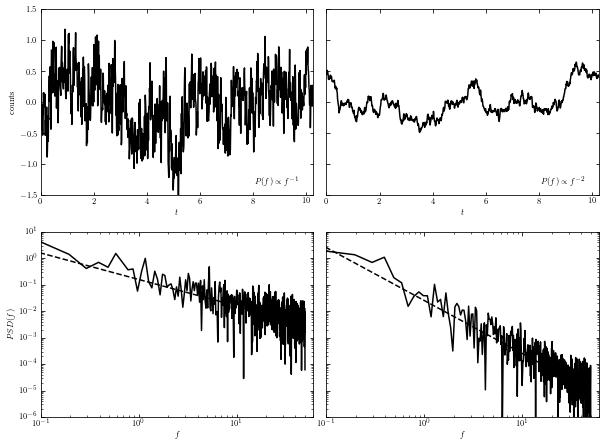

In [41]:
fig = plt.figure(figsize=(10, 7.5))
fig.subplots_adjust(wspace=0.05)

for i, beta in enumerate([1.0, 2.0]):
    # Generate the light curve and compute the PSD
    x = factor * generate_power_law(N, dt, beta, random_state=random_state)
    f, PSD = PSD_continuous(t, x)

    # First axes: plot the time series
    ax1 = fig.add_subplot(221 + i)
    ax1.plot(t, x, '-k')

    ax1.text(0.95, 0.05, r"$P(f) \propto f^{-%i}$" % beta,
             ha='right', va='bottom', transform=ax1.transAxes)

    ax1.set_xlim(0, 10.24)
    ax1.set_ylim(-1.5, 1.5)

    ax1.set_xlabel(r'$t$')

    # Second axes: plot the PSD
    ax2 = fig.add_subplot(223 + i, xscale='log', yscale='log')
    ax2.plot(f, PSD, '-k')
    ax2.plot(f[1:], (factor * dt) ** 2 * (2 * np.pi * f[1:]) ** -beta, '--k')

    ax2.set_xlim(1E-1, 60)
    ax2.set_ylim(1E-6, 1E1)

    ax2.set_xlabel(r'$f$')

    if i == 1:
        ax1.yaxis.set_major_formatter(plt.NullFormatter())
        ax2.yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_ylabel(r'${\rm counts}$')
        ax2.set_ylabel(r'$PSD(f)$')

## Autocorrelation and structure function for evenly and unevenly sampled data
### Evenly sampled data
In the case of **evenly sampled data**, with $t_i = (i-1)\Delta t$, the autocorrelation function of a discretely sampled $y(t)$ is defined as

$$ACF(j) = \frac{\sum^{N-j}_{i=1} [(y_i-\bar{y})(y_{i+j}-\bar{y})]}{\sum^{N}_{i=1}(y_i-\bar{y})^2}$$

The uncertainty of the mean is 

$$\sigma_{\bar{x}} = \frac{\sigma}{\sqrt{N}}[1+2 \sum^N_{j=1}(1-\frac{j}{N})ACF(j)]^{1/2}$$

where $\sigma$ is the homoscedastic measurement error.   
When a time series has a nonvanishing ACF, the uncertainty of its mean is larger than for an uncorrelated data set, where $\sigma_{\bar{x}} = \frac{s}{\sqrt{N}}$.  
When data are unevenly sampled, the ACF cannot be computed using equations above.
  
### Unevenly sampled data
For the case of **unevenly sampled data**, Edelson and Krolik proposed the **"discrete correlation function" (DCF)** in an astronomical context (called the "slot autocorrelation function" in physics). See [The Discrete Correlation Function](https://ui.adsabs.harvard.edu/abs/1988ApJ...333..646E/abstract).  
For discrete unevenly sampled data with homoscedastic errors, they defined a quantity

$$UDCF_{ij} = \frac{(y_i-\bar{y})(g_j-\bar{g})}{[(\sigma_y^2-e_y^2)(\sigma_g^2-e_g^2)^{1/2}]}$$
  
where $e_y$ and $e_g$ are homoscedastic measurement errors for time series y and g. The associated time
lag is $\Delta t_{ij} = ti - tj$. The discrete correlation function at time lag $\Delta t$ is then computed by binning
and averaging $UDCF_{ij}$ over M pairs of points for which $\Delta t-\delta t=2 \leq \delta t_{ij} \leq \Delta t+\delta t/2$, where $\delta t$ is
the bin size. The bin size is a trade-of between accuracy of $DCF(\Delta t)$ and its resolution. Edelson and Krolik showed that even uncorrelated time series will produce values of the cross-correlation $DCF(\Delta t) \sim \pm 1/ \sqrt{M}$.
  
Scargle has developed different techniques to evaluate the discrete Fourier transform, correlation
function and autocorrelation function of unevenly sampled time series (see [Studies in astronomical time series analysis. III.](https://www.osti.gov/biblio/5344858-studies-astronomical-time-series-analysis-iii-fourier-transforms-autocorrelation-functions-cross-correlation-functions-unevenly-spaced-data)).  
Given an unevenly sampled time series, y(t), the essential steps of Scargle's
procedure are as follows:
1. Compute the generalized Lomb-Scargle periodogram for $y(t_i), i = 1,..., N$, namely $P_{LS}(\omega)$.
2. Compute the sampling window function using the generalized Lomb-Scargle periodogram using $z(t_i) = 1, i = 1,..., N$, namely $P_{LS}^W(\omega)$.
3. Compute inverse Fourier transforms for $P_{LS}(\omega)$ and $P^W_{LS}(\omega)$, namely $\rho(t)$ and $\rho^W(t)$, respectively.
4. The autocorrelation function at lag t is $ACF(t) = \rho(t)/ \rho^W(t)$.

### Edelson and Krolik's DCF method and the Scargle method Demonstration
We will see an example of the use of Edelson and Krolik's DCF method and the Scargle method.

#### 1. Generate time-series data
We use do 1000 days worth of magnitudes for this sample data.

In [42]:
t = np.arange(0, 1E3)
z = 2.0
tau = 300
tau_obs = tau / (1. + z)

np.random.seed(6)
y = generate_damped_RW(t, tau=tau, z=z, xmean=20)

# randomly sample 100 of these
ind = np.arange(len(t))
np.random.shuffle(ind)
ind = ind[:100]
ind.sort()
t = t[ind]
y = y[ind]

# add errors
dy = 0.1
y_obs = np.random.normal(y, dy)

#### 2. Compute ACF via Scargle method
We calculate the ACF following Scargle method process.

In [43]:
C_S, t_S = ACF_scargle(t, y_obs, dy,
                       n_omega=2. ** 12, omega_max=np.pi / 5.0)

ind = (t_S >= 0) & (t_S <= 500)
t_S = t_S[ind]
C_S = C_S[ind]

#### 3. Compute ACF via E-K method
We calculate ACF using Edelson and Krolik's DCF method.

In [44]:
C_EK, C_EK_err, bins = ACF_EK(t, y_obs, dy, bins=np.linspace(0, 500, 51))
t_EK = 0.5 * (bins[1:] + bins[:-1])

#### 4. Compare results
Example of the autocorrelation function for a stochastic process is shown below. 
* The top panel shows a simulated light curve generated using a damped random walk model. 
* The bottom panel shows the corresponding autocorrelation function computed using Edelson and Krolik's DCF method and the Scargle method. 
* The solid line shows the input autocorrelation function used to generate the light curve.  

The two methods produce similar results. Errors are easier to compute for the DCF method and this advantage
is crucial when fitting models to the autocorrelation function.

Text(0, 0.5, 'ACF(t)')

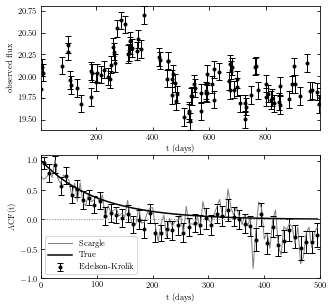

In [45]:
# Plot the results
fig = plt.figure(figsize=(5, 5))

# plot the input data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1)
ax.set_xlabel('t (days)')
ax.set_ylabel('observed flux')

# plot the ACF
ax = fig.add_subplot(212)
ax.plot(t_S, C_S, '-', c='gray', lw=1,
        label='Scargle')
ax.errorbar(t_EK, C_EK, C_EK_err, fmt='.k', lw=1,
            label='Edelson-Krolik')
ax.plot(t_S, np.exp(-abs(t_S) / tau_obs), '-k', label='True')
ax.legend(loc=3)

ax.plot(t_S, 0 * t_S, ':', lw=1, c='gray')

ax.set_xlim(0, 500)
ax.set_ylim(-1.0, 1.1)

ax.set_xlabel('t (days)')
ax.set_ylabel('ACF(t)')

## Autoregressive models
Autocorrelated time series can be analyzed and characterized using stochastic **"autoregressive models."**
Autoregressive models provide a good general description of processes that "retain memory"
of previous states (but are not periodic). An example of such a model is the **random walk**, where
each new value is obtained by adding noise to the preceding value:

$$y_i = y_{i-1} + e_i$$

When $y_{i-1}$ is multiplied by a constant factor greater than 1, the model is known as a geometric
random walk model (used extensively to model stock market data). The noise need not be Gaussian.  
  
The random walk can be generalized to the **linear autoregressive (AR) model** with dependencies
on k past values (i.e., not just one as in the case of random walk). An autoregressive process of
order k, AR(k), for a discrete data set is defined by  

$$y_i = \sum^{k}_{j=1} a_j y_{i-j} + e_i$$

That is, the latest value of y is expressed as a linear combination of the k previous values of y, with
the addition of noise (for random walk, k = 1 and a1 = 1). If the data are drawn from a stationary
process, coefficients aj satisfy certain conditions. The ACF for an AR(k) process is nonzero for all
lags, but it decays quickly.  
  
An autoregressive process defined by $y_i = \sum^{k}_{j=1} a_j y_{i-j} + e_i$ applies only to evenly sampled time series. A
generalization is called the **continuous autoregressive process, CAR(k)**; see [Are the Variations in Quasar Optical Flux Driven by Thermal Fluctuations](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract). The CAR(1)
process has recently received a lot of attention in the context of quasar variability.

In addition to autoregressive models, data can be modeled using the **covariance matrix** (e.g., using
Gaussian process in Gaussian process regression section). For example, for the CAR(1) process,

$$S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$$

where $\sigma$ and $\tau$ are model parameters; $\sigma^2$ controls the short timescale covariance ($t_{ij} \ll \tau$),
which decays exponentially on a timescale given by $\tau$. A number of other convenient models
and parametrizations for the covariance matrix are discussed in the context of quasar variability
in [Is quasar variability a damped random walk?](https://arxiv.org/abs/1202.3783).

## Damped random walk model
The CAR(1) process is described by a stochastic differential equation which includes a damping
term that pushes y(t) back to its mean (see [Is quasar variability a damped random walk?](https://arxiv.org/abs/1202.3783)); 

hence, it is also known as damped random walk. In analogy with calling random walk "drunkard's walk," damped random walk could
be called "married drunkard's walk" (who always comes home instead of drifting away).
Following $S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$, the autocorrelation function for a damped random walk is

$$ACF(t) = exp(-t/ \tau)$$

where $\tau$ is the characteristic timescale (relaxation time, or damping timescale). Given the $ACF$,
it is easy to show that the structure function is

$$SF(t) = SF_{\infty} [1-exp(-t/ \tau)]^{1/2}$$

where $SF_{\infty}$ is the asymptotic value of the structure function equal to $\sqrt{2} \sigma$, where $\sigma$ has the same definition as in $S_{ij} = \sigma^2 exp(-|t_{ij} / \tau|)$. When the structure function applies to differences of the analyzed process

$$PSD(f) = \frac{\tau^2 SF^2_{\infty}}{1+(2 \pi f \tau)^2}$$

Therefore, the damped random walk is a $1/f^2$ process at high frequencies, just as ordinary random
walk. The "damped nature" is seen as the at PSD at low frequencies ($f \ll 2\pi / \tau$). In the previous figure demonstrating E-K method and Scargle method, a light curve generated using a damped random walk is shown in the top panel.  
  
For evenly sampled data, the $CAR(1)$ process is equivalent to the $AR(1)$ process with $a_1 =
exp(-1 / \tau)$, that is, the next value of $y$ is the damping factor times the previous value plus noise.
The noise for the $AR(1)$ process, $\sigma_{AR}$ is related to $SF_{\infty}$ via

$$\sigma_{AR} = \frac{SF_{\infty}}{\sqrt{2}} [1-exp(-2 / \tau)]^{1/2}$$


**Note:** damped random walk model is closely related to Gaussian Processes, which are becoming increasing popular in the context of stochastic variability, but unfortunately we don't have time to cover that...